# Library imports, setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data import load_metadata, visualize_data, make_dataset
from model import build_multitask_model
from score_metrics import get_scores
from loss import SoftF1Loss

2025-11-18 19:09:02.220966: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 19:09:02.265976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 19:09:03.182812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# check tf version
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)
    print(f"Found GPU {device.name}, and set memory growth to True.")


2.20.0
Found GPU /physical_device:GPU:0, and set memory growth to True.


# Loading data

In [4]:
image_metadata, species_metadata = load_metadata()
num_classes = len(species_metadata)

Number of classes: 296


/mnt/d/Egyetem_adat/kigyo2/snek/src/Models/data.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["encoded_id"] = encoder.fit_transform(image_metadata["class_id"])
/mnt/d/Egyetem_adat/kigyo2/snek/src/Models/data.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["image_path"] = image_metadata["image_path"].apply(


# Visualizing data

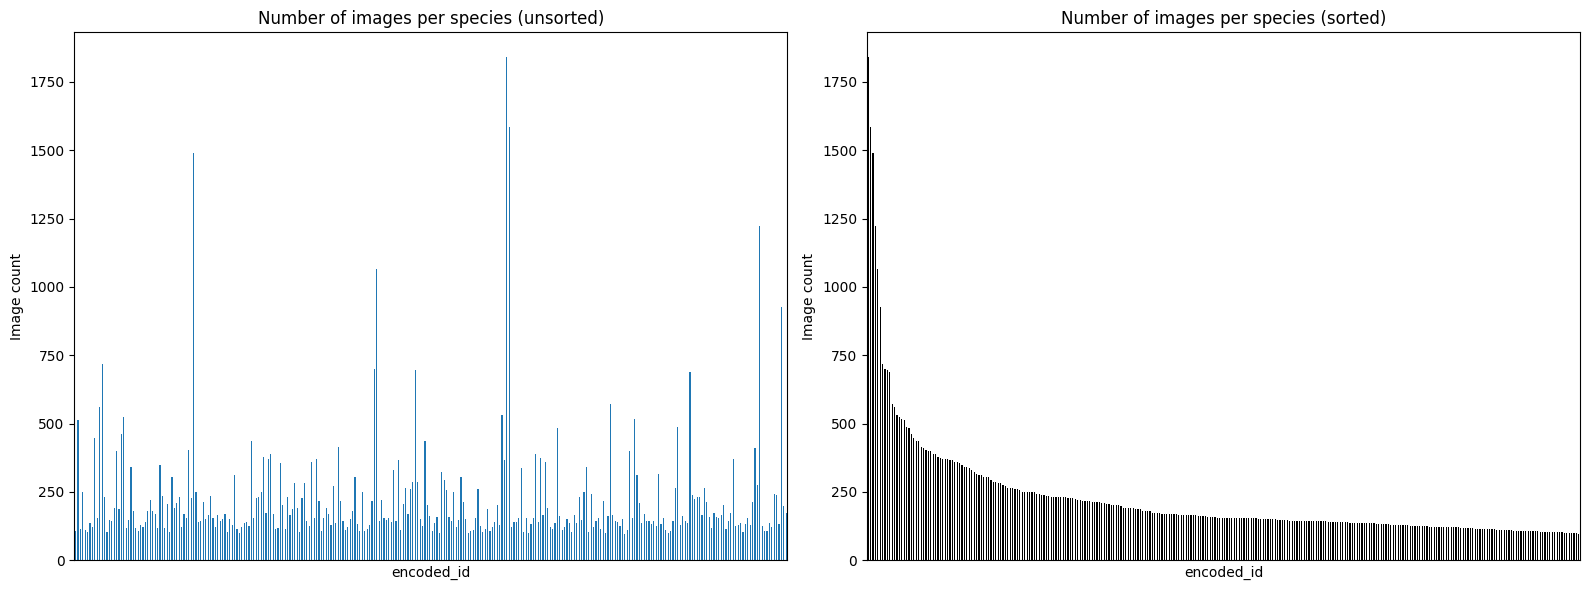

Maximum number per species class is 1839
Minimum number per species class is 96


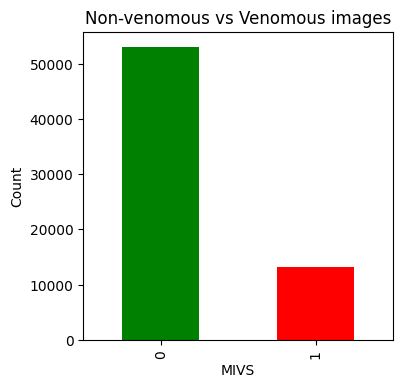

MIVS
0    53164
1    13290
Name: count, dtype: int64


In [5]:
#in data.py
visualize_data(image_metadata)

Loading python images from folder

# Building model

In [6]:
import tensorflow as tf
import keras

In [7]:
IMAGE_RESOLUTION=224
from data import make_batches, split_dataset

#szükség van külön a train infora is
train_info, val_info, test_info = split_dataset(image_metadata)
train_dataset = make_batches(train_info, IMAGE_RESOLUTION)
val_dataset   = make_batches(val_info, IMAGE_RESOLUTION)
test_dataset  = make_batches(test_info, IMAGE_RESOLUTION)


#train_dataset, val_dataset, test_dataset = make_dataset(image_metadata, IMAGE_RESOLUTION)

I0000 00:00:1763489345.278205    4416 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
model = build_multitask_model(num_species=num_classes, image_resolution=IMAGE_RESOLUTION)
#model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
lr = 1e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    
    loss={'species': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          'venom': 'binary_crossentropy',},
    loss_weights={"species": 1.0, "venom": 0.5},
    metrics={'species': 'accuracy',
             'venom': 'accuracy'}
    )

In [10]:
import keras.callbacks

In [11]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

early_stop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)


In [12]:
from sklearn.utils.class_weight import compute_class_weight

# species class_weight
species_classes = np.unique(train_info["encoded_id"])

species_cw = compute_class_weight(
    class_weight="balanced",
    classes=species_classes,
    y=train_info["encoded_id"]
)

species_cw_dict = {int(c): w for c, w in zip(species_classes, species_cw)}

# venom class_weight 
venom_classes = np.unique(train_info["MIVS"]) 
venom_cw = compute_class_weight(
    class_weight="balanced",
    classes=venom_classes,
    y=train_info["MIVS"]
)

venom_cw_dict = {int(c): w for c, w in zip(venom_classes, venom_cw)}


In [13]:
num_species = len(species_cw_dict)


In [14]:
n_epochs = 30

# checkpointing based on the validation loss
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'best_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

#reduce learning rate on plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6
)


class_weight = {
    "species": species_cw_dict,
    "venom": venom_cw_dict,
}

In [15]:
model_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=n_epochs,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb]
)

Epoch 1/30


/home/janos/tf-gpu/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2025-11-18 19:09:14.234764: I external/local_xla/xla/service/service.cc:163] XLA service 0x715e24003920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-18 19:09:14.234822: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-18 19:09:14.488832: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-18 19:09:15.529142: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500
2025-11-18 19:09:16.

 560/1662 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - loss: 5.7799 - species_accuracy: 0.0287 - species_loss: 5.5283 - venom_accuracy: 0.7771 - venom_loss: 0.5034

2025-11-18 19:09:57.363025: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.4882 - species_accuracy: 0.0563 - species_loss: 5.2541 - venom_accuracy: 0.7972 - venom_loss: 0.4683

2025-11-18 19:11:09.637614: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 19:11:09.815274: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 19:11:09.994500: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 19:11:10.578679: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-18 19:11:10.781291: E external/local_xla/xla/stream_

1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 5.4880 - species_accuracy: 0.0563 - species_loss: 5.2539 - venom_accuracy: 0.7972 - venom_loss: 0.4683

2025-11-18 19:11:43.241616: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv (f32[21,480,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,480,14,14]{3,2,1,0}, f32[480,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=480, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-18 19:11:43.520117: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.278630218s
Trying algorithm eng3{k11=0} for conv (f32[21,480,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,480,14,14]{3,2,1,0}, f32[480,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=480, custom_call_target="__cudnn


Epoch 1: val_loss improved from None to 4.47477, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 161s 81ms/step - loss: 5.1346 - species_accuracy: 0.0874 - species_loss: 4.9131 - venom_accuracy: 0.8100 - venom_loss: 0.4422 - val_loss: 4.4748 - val_species_accuracy: 0.1464 - val_species_loss: 4.2708 - val_venom_accuracy: 0.8205 - val_venom_loss: 0.4088 - learning_rate: 1.0000e-04
Epoch 2/30
 687/1662 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - loss: 4.4481 - species_accuracy: 0.1442 - species_loss: 4.2371 - venom_accuracy: 0.8203 - venom_loss: 0.4220

2025-11-18 19:12:22.334078: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 4.3977 - species_accuracy: 0.1483 - species_loss: 4.1868 - venom_accuracy: 0.8194 - venom_loss: 0.4219
Epoch 2: val_loss improved from 4.47477 to 4.03447, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 113s 68ms/step - loss: 4.3077 - species_accuracy: 0.1573 - species_loss: 4.0972 - venom_accuracy: 0.8192 - venom_loss: 0.4210 - val_loss: 4.0345 - val_species_accuracy: 0.1934 - val_species_loss: 3.8340 - val_venom_accuracy: 0.8226 - val_venom_loss: 0.4004 - learning_rate: 1.0000e-04
Epoch 3/30
 567/1662 ━━━━━━━━━━━━━━━━━━━━ 53s 49ms/step - loss: 4.0402 - species_accuracy: 0.1849 - species_loss: 3.8314 - venom_accuracy: 0.8208 - venom_loss: 0.4176

2025-11-18 19:14:10.634917: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 4.0125 - species_accuracy: 0.1911 - species_loss: 3.8051 - venom_accuracy: 0.8212 - venom_loss: 0.4148
Epoch 3: val_loss improved from 4.03447 to 3.84392, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 122s 73ms/step - loss: 3.9758 - species_accuracy: 0.1972 - species_loss: 3.7691 - venom_accuracy: 0.8217 - venom_loss: 0.4131 - val_loss: 3.8439 - val_species_accuracy: 0.2122 - val_species_loss: 3.6462 - val_venom_accuracy: 0.8256 - val_venom_loss: 0.3955 - learning_rate: 1.0000e-04
Epoch 4/30
 808/1662 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - loss: 3.7997 - species_accuracy: 0.2228 - species_loss: 3.5941 - venom_accuracy: 0.8232 - venom_loss: 0.4112

2025-11-18 19:16:22.331739: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 3.7938 - species_accuracy: 0.2216 - species_loss: 3.5899 - venom_accuracy: 0.8243 - venom_loss: 0.4079
Epoch 4: val_loss improved from 3.84392 to 3.72676, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 113s 68ms/step - loss: 3.7760 - species_accuracy: 0.2216 - species_loss: 3.5725 - venom_accuracy: 0.8247 - venom_loss: 0.4062 - val_loss: 3.7268 - val_species_accuracy: 0.2286 - val_species_loss: 3.5309 - val_venom_accuracy: 0.8280 - val_venom_loss: 0.3921 - learning_rate: 1.0000e-04
Epoch 5/30
 789/1662 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - loss: 3.6370 - species_accuracy: 0.2461 - species_loss: 3.4389 - venom_accuracy: 0.8270 - venom_loss: 0.3963

2025-11-18 19:18:11.965318: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 3.6354 - species_accuracy: 0.2452 - species_loss: 3.4365 - venom_accuracy: 0.8267 - venom_loss: 0.3978
Epoch 5: val_loss improved from 3.72676 to 3.64629, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 108s 65ms/step - loss: 3.6329 - species_accuracy: 0.2437 - species_loss: 3.4325 - venom_accuracy: 0.8256 - venom_loss: 0.4009 - val_loss: 3.6463 - val_species_accuracy: 0.2430 - val_species_loss: 3.4509 - val_venom_accuracy: 0.8269 - val_venom_loss: 0.3903 - learning_rate: 1.0000e-04
Epoch 6/30
 565/1662 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 3.5093 - species_accuracy: 0.2598 - species_loss: 3.3062 - venom_accuracy: 0.8229 - venom_loss: 0.4062

2025-11-18 19:19:44.814061: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.5188 - species_accuracy: 0.2600 - species_loss: 3.3187 - venom_accuracy: 0.8257 - venom_loss: 0.4001
Epoch 6: val_loss improved from 3.64629 to 3.58182, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 61s 36ms/step - loss: 3.5169 - species_accuracy: 0.2621 - species_loss: 3.3180 - venom_accuracy: 0.8260 - venom_loss: 0.3978 - val_loss: 3.5818 - val_species_accuracy: 0.2533 - val_species_loss: 3.3868 - val_venom_accuracy: 0.8309 - val_venom_loss: 0.3894 - learning_rate: 1.0000e-04
Epoch 7/30
1067/1662 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 3.4282 - species_accuracy: 0.2735 - species_loss: 3.2315 - venom_accuracy: 0.8301 - venom_loss: 0.3935

2025-11-18 19:21:00.137708: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.4216 - species_accuracy: 0.2748 - species_loss: 3.2253 - venom_accuracy: 0.8306 - venom_loss: 0.3927
Epoch 7: val_loss improved from 3.58182 to 3.53142, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - loss: 3.4092 - species_accuracy: 0.2774 - species_loss: 3.2134 - venom_accuracy: 0.8308 - venom_loss: 0.3919 - val_loss: 3.5314 - val_species_accuracy: 0.2609 - val_species_loss: 3.3376 - val_venom_accuracy: 0.8293 - val_venom_loss: 0.3866 - learning_rate: 1.0000e-04
Epoch 8/30
 517/1662 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - loss: 3.3029 - species_accuracy: 0.2868 - species_loss: 3.1072 - venom_accuracy: 0.8284 - venom_loss: 0.3914

2025-11-18 19:21:41.753438: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.3157 - species_accuracy: 0.2905 - species_loss: 3.1211 - venom_accuracy: 0.8312 - venom_loss: 0.3892
Epoch 8: val_loss improved from 3.53142 to 3.48736, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - loss: 3.3240 - species_accuracy: 0.2923 - species_loss: 3.1296 - venom_accuracy: 0.8314 - venom_loss: 0.3890 - val_loss: 3.4874 - val_species_accuracy: 0.2671 - val_species_loss: 3.2948 - val_venom_accuracy: 0.8302 - val_venom_loss: 0.3873 - learning_rate: 1.0000e-04
Epoch 9/30
1593/1662 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.2479 - species_accuracy: 0.3015 - species_loss: 3.0526 - venom_accuracy: 0.8326 - venom_loss: 0.3906

2025-11-18 19:23:15.482859: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.2477 - species_accuracy: 0.3017 - species_loss: 3.0525 - venom_accuracy: 0.8326 - venom_loss: 0.3904
Epoch 9: val_loss improved from 3.48736 to 3.45204, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - loss: 3.2411 - species_accuracy: 0.3050 - species_loss: 3.0484 - venom_accuracy: 0.8338 - venom_loss: 0.3860 - val_loss: 3.4520 - val_species_accuracy: 0.2748 - val_species_loss: 3.2601 - val_venom_accuracy: 0.8310 - val_venom_loss: 0.3861 - learning_rate: 1.0000e-04
Epoch 10/30
 843/1662 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 3.1658 - species_accuracy: 0.3191 - species_loss: 2.9737 - venom_accuracy: 0.8337 - venom_loss: 0.3842

2025-11-18 19:23:51.050976: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.1691 - species_accuracy: 0.3181 - species_loss: 2.9770 - venom_accuracy: 0.8341 - venom_loss: 0.3841
Epoch 10: val_loss improved from 3.45204 to 3.42199, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 59s 36ms/step - loss: 3.1719 - species_accuracy: 0.3166 - species_loss: 2.9797 - venom_accuracy: 0.8339 - venom_loss: 0.3846 - val_loss: 3.4220 - val_species_accuracy: 0.2795 - val_species_loss: 3.2288 - val_venom_accuracy: 0.8324 - val_venom_loss: 0.3850 - learning_rate: 1.0000e-04
Epoch 11/30
1479/1662 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3.1044 - species_accuracy: 0.3282 - species_loss: 2.9139 - venom_accuracy: 0.8357 - venom_loss: 0.3809

2025-11-18 19:25:10.329267: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.1044 - species_accuracy: 0.3282 - species_loss: 2.9138 - venom_accuracy: 0.8357 - venom_loss: 0.3811
Epoch 11: val_loss improved from 3.42199 to 3.39726, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 59s 36ms/step - loss: 3.1042 - species_accuracy: 0.3281 - species_loss: 2.9127 - venom_accuracy: 0.8355 - venom_loss: 0.3831 - val_loss: 3.3973 - val_species_accuracy: 0.2847 - val_species_loss: 3.2043 - val_venom_accuracy: 0.8315 - val_venom_loss: 0.3842 - learning_rate: 1.0000e-04
Epoch 12/30
 595/1662 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - loss: 3.0541 - species_accuracy: 0.3374 - species_loss: 2.8627 - venom_accuracy: 0.8298 - venom_loss: 0.3828

2025-11-18 19:25:41.435074: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.0466 - species_accuracy: 0.3403 - species_loss: 2.8561 - venom_accuracy: 0.8330 - venom_loss: 0.3809
Epoch 12: val_loss improved from 3.39726 to 3.37662, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 59s 36ms/step - loss: 3.0424 - species_accuracy: 0.3413 - species_loss: 2.8518 - venom_accuracy: 0.8347 - venom_loss: 0.3807 - val_loss: 3.3766 - val_species_accuracy: 0.2841 - val_species_loss: 3.1853 - val_venom_accuracy: 0.8301 - val_venom_loss: 0.3838 - learning_rate: 1.0000e-04
Epoch 13/30
 755/1662 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - loss: 3.0015 - species_accuracy: 0.3486 - species_loss: 2.8117 - venom_accuracy: 0.8359 - venom_loss: 0.3795

2025-11-18 19:26:45.967011: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.9946 - species_accuracy: 0.3505 - species_loss: 2.8048 - venom_accuracy: 0.8366 - venom_loss: 0.3797
Epoch 13: val_loss improved from 3.37662 to 3.35386, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - loss: 2.9848 - species_accuracy: 0.3530 - species_loss: 2.7949 - venom_accuracy: 0.8363 - venom_loss: 0.3792 - val_loss: 3.3539 - val_species_accuracy: 0.2945 - val_species_loss: 3.1615 - val_venom_accuracy: 0.8327 - val_venom_loss: 0.3827 - learning_rate: 1.0000e-04
Epoch 14/30
 869/1662 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - loss: 2.9061 - species_accuracy: 0.3648 - species_loss: 2.7188 - venom_accuracy: 0.8350 - venom_loss: 0.3745

2025-11-18 19:27:50.674963: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.9140 - species_accuracy: 0.3633 - species_loss: 2.7263 - venom_accuracy: 0.8356 - venom_loss: 0.3755
Epoch 14: val_loss improved from 3.35386 to 3.33766, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 61s 36ms/step - loss: 2.9243 - species_accuracy: 0.3612 - species_loss: 2.7352 - venom_accuracy: 0.8354 - venom_loss: 0.3774 - val_loss: 3.3377 - val_species_accuracy: 0.2936 - val_species_loss: 3.1457 - val_venom_accuracy: 0.8330 - val_venom_loss: 0.3829 - learning_rate: 1.0000e-04
Epoch 15/30
 651/1662 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - loss: 2.8435 - species_accuracy: 0.3775 - species_loss: 2.6550 - venom_accuracy: 0.8347 - venom_loss: 0.3771

2025-11-18 19:28:43.814362: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.8622 - species_accuracy: 0.3738 - species_loss: 2.6744 - venom_accuracy: 0.8365 - venom_loss: 0.3755
Epoch 15: val_loss improved from 3.33766 to 3.32250, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 59s 36ms/step - loss: 2.8754 - species_accuracy: 0.3718 - species_loss: 2.6875 - venom_accuracy: 0.8370 - venom_loss: 0.3757 - val_loss: 3.3225 - val_species_accuracy: 0.3020 - val_species_loss: 3.1303 - val_venom_accuracy: 0.8325 - val_venom_loss: 0.3822 - learning_rate: 1.0000e-04
Epoch 16/30
 831/1662 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - loss: 2.8047 - species_accuracy: 0.3876 - species_loss: 2.6172 - venom_accuracy: 0.8387 - venom_loss: 0.3751

2025-11-18 19:29:48.835004: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.8129 - species_accuracy: 0.3860 - species_loss: 2.6258 - venom_accuracy: 0.8389 - venom_loss: 0.3742
Epoch 16: val_loss improved from 3.32250 to 3.30938, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - loss: 2.8218 - species_accuracy: 0.3845 - species_loss: 2.6349 - venom_accuracy: 0.8380 - venom_loss: 0.3750 - val_loss: 3.3094 - val_species_accuracy: 0.3001 - val_species_loss: 3.1187 - val_venom_accuracy: 0.8327 - val_venom_loss: 0.3823 - learning_rate: 1.0000e-04
Epoch 17/30
 785/1662 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - loss: 2.7723 - species_accuracy: 0.3887 - species_loss: 2.5856 - venom_accuracy: 0.8405 - venom_loss: 0.3734

2025-11-18 19:30:46.697418: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.7736 - species_accuracy: 0.3891 - species_loss: 2.5871 - venom_accuracy: 0.8395 - venom_loss: 0.3731
Epoch 17: val_loss improved from 3.30938 to 3.29455, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - loss: 2.7792 - species_accuracy: 0.3894 - species_loss: 2.5927 - venom_accuracy: 0.8388 - venom_loss: 0.3725 - val_loss: 3.2945 - val_species_accuracy: 0.3085 - val_species_loss: 3.1031 - val_venom_accuracy: 0.8327 - val_venom_loss: 0.3813 - learning_rate: 1.0000e-04
Epoch 18/30
 511/1662 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - loss: 2.7109 - species_accuracy: 0.4067 - species_loss: 2.5225 - venom_accuracy: 0.8402 - venom_loss: 0.3768

2025-11-18 19:31:36.984542: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.7215 - species_accuracy: 0.4024 - species_loss: 2.5347 - venom_accuracy: 0.8396 - venom_loss: 0.3736
Epoch 18: val_loss improved from 3.29455 to 3.28623, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - loss: 2.7304 - species_accuracy: 0.4006 - species_loss: 2.5444 - venom_accuracy: 0.8391 - venom_loss: 0.3715 - val_loss: 3.2862 - val_species_accuracy: 0.3106 - val_species_loss: 3.0949 - val_venom_accuracy: 0.8330 - val_venom_loss: 0.3814 - learning_rate: 1.0000e-04
Epoch 19/30
 637/1662 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - loss: 2.6494 - species_accuracy: 0.4179 - species_loss: 2.4645 - venom_accuracy: 0.8382 - venom_loss: 0.3699

2025-11-18 19:32:39.620584: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.6683 - species_accuracy: 0.4133 - species_loss: 2.4832 - venom_accuracy: 0.8390 - venom_loss: 0.3701
Epoch 19: val_loss improved from 3.28623 to 3.27416, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - loss: 2.6868 - species_accuracy: 0.4080 - species_loss: 2.5008 - venom_accuracy: 0.8381 - venom_loss: 0.3720 - val_loss: 3.2742 - val_species_accuracy: 0.3073 - val_species_loss: 3.0830 - val_venom_accuracy: 0.8333 - val_venom_loss: 0.3812 - learning_rate: 1.0000e-04
Epoch 20/30
 877/1662 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - loss: 2.6585 - species_accuracy: 0.4105 - species_loss: 2.4736 - venom_accuracy: 0.8415 - venom_loss: 0.3698

2025-11-18 19:33:47.775609: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.6496 - species_accuracy: 0.4135 - species_loss: 2.4650 - venom_accuracy: 0.8410 - venom_loss: 0.3693
Epoch 20: val_loss improved from 3.27416 to 3.27043, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 61s 37ms/step - loss: 2.6412 - species_accuracy: 0.4158 - species_loss: 2.4564 - venom_accuracy: 0.8397 - venom_loss: 0.3693 - val_loss: 3.2704 - val_species_accuracy: 0.3130 - val_species_loss: 3.0802 - val_venom_accuracy: 0.8357 - val_venom_loss: 0.3804 - learning_rate: 1.0000e-04
Epoch 21/30
 581/1662 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - loss: 2.5934 - species_accuracy: 0.4250 - species_loss: 2.4074 - venom_accuracy: 0.8372 - venom_loss: 0.3721

2025-11-18 19:34:39.841469: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.5979 - species_accuracy: 0.4244 - species_loss: 2.4130 - venom_accuracy: 0.8382 - venom_loss: 0.3697
Epoch 21: val_loss improved from 3.27043 to 3.26753, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 61s 36ms/step - loss: 2.6017 - species_accuracy: 0.4241 - species_loss: 2.4178 - venom_accuracy: 0.8395 - venom_loss: 0.3685 - val_loss: 3.2675 - val_species_accuracy: 0.3105 - val_species_loss: 3.0768 - val_venom_accuracy: 0.8340 - val_venom_loss: 0.3810 - learning_rate: 1.0000e-04
Epoch 22/30
 517/1662 ━━━━━━━━━━━━━━━━━━━━ 36s 32ms/step - loss: 2.5513 - species_accuracy: 0.4317 - species_loss: 2.3666 - venom_accuracy: 0.8389 - venom_loss: 0.3694

2025-11-18 19:35:37.733677: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.5587 - species_accuracy: 0.4324 - species_loss: 2.3744 - venom_accuracy: 0.8395 - venom_loss: 0.3688
Epoch 22: val_loss improved from 3.26753 to 3.25669, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 61s 37ms/step - loss: 2.5670 - species_accuracy: 0.4321 - species_loss: 2.3834 - venom_accuracy: 0.8400 - venom_loss: 0.3670 - val_loss: 3.2567 - val_species_accuracy: 0.3135 - val_species_loss: 3.0652 - val_venom_accuracy: 0.8342 - val_venom_loss: 0.3810 - learning_rate: 1.0000e-04
Epoch 23/30
 941/1662 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - loss: 2.4962 - species_accuracy: 0.4443 - species_loss: 2.3131 - venom_accuracy: 0.8420 - venom_loss: 0.3663

2025-11-18 19:36:52.926824: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.5053 - species_accuracy: 0.4433 - species_loss: 2.3223 - venom_accuracy: 0.8423 - venom_loss: 0.3659
Epoch 23: val_loss improved from 3.25669 to 3.24886, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 62s 37ms/step - loss: 2.5209 - species_accuracy: 0.4414 - species_loss: 2.3378 - venom_accuracy: 0.8420 - venom_loss: 0.3656 - val_loss: 3.2489 - val_species_accuracy: 0.3129 - val_species_loss: 3.0591 - val_venom_accuracy: 0.8345 - val_venom_loss: 0.3798 - learning_rate: 1.0000e-04
Epoch 24/30
 658/1662 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - loss: 2.4666 - species_accuracy: 0.4515 - species_loss: 2.2842 - venom_accuracy: 0.8392 - venom_loss: 0.3648

2025-11-18 19:37:45.534505: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1660/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.4704 - species_accuracy: 0.4521 - species_loss: 2.2889 - venom_accuracy: 0.8421 - venom_loss: 0.3631
Epoch 24: val_loss improved from 3.24886 to 3.24387, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 59s 36ms/step - loss: 2.4777 - species_accuracy: 0.4503 - species_loss: 2.2960 - venom_accuracy: 0.8427 - venom_loss: 0.3634 - val_loss: 3.2439 - val_species_accuracy: 0.3189 - val_species_loss: 3.0535 - val_venom_accuracy: 0.8345 - val_venom_loss: 0.3803 - learning_rate: 1.0000e-04
Epoch 25/30
 979/1662 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 2.4381 - species_accuracy: 0.4602 - species_loss: 2.2540 - venom_accuracy: 0.8388 - venom_loss: 0.3682

2025-11-18 19:38:54.884232: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.4401 - species_accuracy: 0.4596 - species_loss: 2.2572 - venom_accuracy: 0.8403 - venom_loss: 0.3657
Epoch 25: val_loss improved from 3.24387 to 3.23923, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - loss: 2.4469 - species_accuracy: 0.4581 - species_loss: 2.2656 - venom_accuracy: 0.8419 - venom_loss: 0.3630 - val_loss: 3.2392 - val_species_accuracy: 0.3201 - val_species_loss: 3.0486 - val_venom_accuracy: 0.8340 - val_venom_loss: 0.3795 - learning_rate: 1.0000e-04
Epoch 26/30
 809/1662 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 2.3965 - species_accuracy: 0.4691 - species_loss: 2.2163 - venom_accuracy: 0.8454 - venom_loss: 0.3605

2025-11-18 19:39:50.604280: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.3996 - species_accuracy: 0.4672 - species_loss: 2.2192 - venom_accuracy: 0.8448 - venom_loss: 0.3610
Epoch 26: val_loss improved from 3.23923 to 3.23611, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 61s 37ms/step - loss: 2.4103 - species_accuracy: 0.4641 - species_loss: 2.2291 - venom_accuracy: 0.8427 - venom_loss: 0.3627 - val_loss: 3.2361 - val_species_accuracy: 0.3192 - val_species_loss: 3.0468 - val_venom_accuracy: 0.8351 - val_venom_loss: 0.3795 - learning_rate: 1.0000e-04
Epoch 27/30
 715/1662 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - loss: 2.3360 - species_accuracy: 0.4829 - species_loss: 2.1541 - venom_accuracy: 0.8411 - venom_loss: 0.3638

2025-11-18 19:40:48.833586: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.3578 - species_accuracy: 0.4764 - species_loss: 2.1766 - venom_accuracy: 0.8422 - venom_loss: 0.3623
Epoch 27: val_loss improved from 3.23611 to 3.23447, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 61s 37ms/step - loss: 2.3743 - species_accuracy: 0.4707 - species_loss: 2.1937 - venom_accuracy: 0.8425 - venom_loss: 0.3615 - val_loss: 3.2345 - val_species_accuracy: 0.3214 - val_species_loss: 3.0441 - val_venom_accuracy: 0.8354 - val_venom_loss: 0.3786 - learning_rate: 1.0000e-04
Epoch 28/30
 603/1662 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - loss: 2.3071 - species_accuracy: 0.4840 - species_loss: 2.1243 - venom_accuracy: 0.8381 - venom_loss: 0.3656

2025-11-18 19:41:46.353322: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.3265 - species_accuracy: 0.4800 - species_loss: 2.1458 - venom_accuracy: 0.8421 - venom_loss: 0.3615
Epoch 28: val_loss did not improve from 3.23447
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - loss: 2.3441 - species_accuracy: 0.4771 - species_loss: 2.1644 - venom_accuracy: 0.8447 - venom_loss: 0.3593 - val_loss: 3.2351 - val_species_accuracy: 0.3216 - val_species_loss: 3.0456 - val_venom_accuracy: 0.8352 - val_venom_loss: 0.3799 - learning_rate: 1.0000e-04
Epoch 29/30
 859/1662 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 2.2894 - species_accuracy: 0.4866 - species_loss: 2.1085 - venom_accuracy: 0.8426 - venom_loss: 0.3618

2025-11-18 19:42:55.414602: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.2944 - species_accuracy: 0.4870 - species_loss: 2.1144 - venom_accuracy: 0.8440 - venom_loss: 0.3600
Epoch 29: val_loss improved from 3.23447 to 3.22953, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 62s 37ms/step - loss: 2.3052 - species_accuracy: 0.4856 - species_loss: 2.1251 - venom_accuracy: 0.8437 - venom_loss: 0.3605 - val_loss: 3.2295 - val_species_accuracy: 0.3231 - val_species_loss: 3.0406 - val_venom_accuracy: 0.8354 - val_venom_loss: 0.3780 - learning_rate: 1.0000e-04
Epoch 30/30
1225/1662 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 2.2760 - species_accuracy: 0.4905 - species_loss: 2.0947 - venom_accuracy: 0.8430 - venom_loss: 0.3624

2025-11-18 19:44:08.439117: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.2761 - species_accuracy: 0.4903 - species_loss: 2.0953 - venom_accuracy: 0.8435 - venom_loss: 0.3617
Epoch 30: val_loss did not improve from 3.22953
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - loss: 2.2778 - species_accuracy: 0.4902 - species_loss: 2.0980 - venom_accuracy: 0.8447 - venom_loss: 0.3598 - val_loss: 3.2296 - val_species_accuracy: 0.3208 - val_species_loss: 3.0401 - val_venom_accuracy: 0.8339 - val_venom_loss: 0.3778 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 29.


In [33]:
model.load_weights('best_model.keras')  # load weights back

/home/janos/tf-gpu/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 13 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 134 objects could not be loaded. Example error message for object <Normalization name=normalization, built=True>:

Layer 'normalization' expected 3 variables, but received 0 variables during loading. Expected: ['mean', 'variance', 'count']

List of objects that could not be loaded:
[<Normalization name=normalization, built=True>, <Conv2D name=stem_conv, built=True>, <BatchNormalization name=stem_bn, built=True>, <DepthwiseConv2D name=block1a_dwconv, built=True>, <BatchNormalization name=block1a_bn, built=True>, <Conv2D name=block1a_se_reduce, built=True>, <Conv2D name=block1a_se_expand, built=True>, <Conv2D name=block1a_project_conv, built=True>, <BatchNormalization name=block1a_project_bn, built=True>, <Conv2D name=block2a_expand_conv, built=True>, <BatchNormalization name=block2a_expand_bn, built=True>, <DepthwiseConv2D name=block2a_dwconv, built=True>, <BatchNormalization name=block2a_bn, built=True>, <Conv2D name=block2a_se_reduce, built=True>, <Conv2D name=block2a_se_expand, built=True>, <Conv2D name=block2a_project_conv, built=True>, <BatchNormalization name=block2a_project_bn, built=True>, <Conv2D name=block2b_expand_conv, built=True>, <BatchNormalization name=block2b_expand_bn, built=True>, <DepthwiseConv2D name=block2b_dwconv, built=True>, <BatchNormalization name=block2b_bn, built=True>, <Conv2D name=block2b_se_reduce, built=True>, <Conv2D name=block2b_se_expand, built=True>, <Conv2D name=block2b_project_conv, built=True>, <BatchNormalization name=block2b_project_bn, built=True>, <Conv2D name=block3a_expand_conv, built=True>, <BatchNormalization name=block3a_expand_bn, built=True>, <DepthwiseConv2D name=block3a_dwconv, built=True>, <BatchNormalization name=block3a_bn, built=True>, <Conv2D name=block3a_se_reduce, built=True>, <Conv2D name=block3a_se_expand, built=True>, <Conv2D name=block3a_project_conv, built=True>, <BatchNormalization name=block3a_project_bn, built=True>, <Conv2D name=block3b_expand_conv, built=True>, <BatchNormalization name=block3b_expand_bn, built=True>, <DepthwiseConv2D name=block3b_dwconv, built=True>, <BatchNormalization name=block3b_bn, built=True>, <Conv2D name=block3b_se_reduce, built=True>, <Conv2D name=block3b_se_expand, built=True>, <Conv2D name=block3b_project_conv, built=True>, <BatchNormalization name=block3b_project_bn, built=True>, <Conv2D name=block4a_expand_conv, built=True>, <BatchNormalization name=block4a_expand_bn, built=True>, <DepthwiseConv2D name=block4a_dwconv, built=True>, <BatchNormalization name=block4a_bn, built=True>, <Conv2D name=block4a_se_reduce, built=True>, <Conv2D name=block4a_se_expand, built=True>, <Conv2D name=block4a_project_conv, built=True>, <BatchNormalization name=block4a_project_bn, built=True>, <Conv2D name=block4b_expand_conv, built=True>, <BatchNormalization name=block4b_expand_bn, built=True>, <DepthwiseConv2D name=block4b_dwconv, built=True>, <BatchNormalization name=block4b_bn, built=True>, <Conv2D name=block4b_se_reduce, built=True>, <Conv2D name=block4b_se_expand, built=True>, <Conv2D name=block4b_project_conv, built=True>, <BatchNormalization name=block4b_project_bn, built=True>, <Conv2D name=block4c_expand_conv, built=True>, <BatchNormalization name=block4c_expand_bn, built=True>, <DepthwiseConv2D name=block4c_dwconv, built=True>, <BatchNormalization name=block4c_bn, built=True>, <Conv2D name=block4c_se_reduce, built=True>, <Conv2D name=block4c_se_expand, built=True>, <Conv2D name=block4c_project_conv, built=True>, <BatchNormalization name=block4c_project_bn, built=True>, <Conv2D name=block5a_expand_conv, built=True>, <BatchNormalization name=block5a_expand_bn, built=True>, <DepthwiseConv2D name=block5a_dwconv, built=True>, <BatchNormalization name=block5a_bn, built=True>, <Conv2D name=block5a_se_reduce, built=True>, <Conv2D name=block5a_se_expand, built=True>, <Conv2D name=block5a_project_conv, built=True>, <BatchNormalization name=block5a_project_bn, built=True>, <Conv2D name=block5b_expand_conv, built=True>, <BatchNormalization name=block5b_expand_bn, built=True>, <DepthwiseConv2D name=block5b_dwconv, built=True>, <BatchNormalization name=block5b_bn, built=True>, <Conv2D name=block5b_se_reduce, built=True>, <Conv2D name=block5b_se_expand, built=True>, <Conv2D name=block5b_project_conv, built=True>, <BatchNormalization name=block5b_project_bn, built=True>, <Conv2D name=block5c_expand_conv, built=True>, <BatchNormalization name=block5c_expand_bn, built=True>, <DepthwiseConv2D name=block5c_dwconv, built=True>, <BatchNormalization name=block5c_bn, built=True>, <Conv2D name=block5c_se_reduce, built=True>, <Conv2D name=block5c_se_expand, built=True>, <Conv2D name=block5c_project_conv, built=True>, <BatchNormalization name=block5c_project_bn, built=True>, <Conv2D name=block6a_expand_conv, built=True>, <BatchNormalization name=block6a_expand_bn, built=True>, <DepthwiseConv2D name=block6a_dwconv, built=True>, <BatchNormalization name=block6a_bn, built=True>, <Conv2D name=block6a_se_reduce, built=True>, <Conv2D name=block6a_se_expand, built=True>, <Conv2D name=block6a_project_conv, built=True>, <BatchNormalization name=block6a_project_bn, built=True>, <Conv2D name=block6b_expand_conv, built=True>, <BatchNormalization name=block6b_expand_bn, built=True>, <DepthwiseConv2D name=block6b_dwconv, built=True>, <BatchNormalization name=block6b_bn, built=True>, <Conv2D name=block6b_se_reduce, built=True>, <Conv2D name=block6b_se_expand, built=True>, <Conv2D name=block6b_project_conv, built=True>, <BatchNormalization name=block6b_project_bn, built=True>, <Conv2D name=block6c_expand_conv, built=True>, <BatchNormalization name=block6c_expand_bn, built=True>, <DepthwiseConv2D name=block6c_dwconv, built=True>, <BatchNormalization name=block6c_bn, built=True>, <Conv2D name=block6c_se_reduce, built=True>, <Conv2D name=block6c_se_expand, built=True>, <Conv2D name=block6c_project_conv, built=True>, <BatchNormalization name=block6c_project_bn, built=True>, <Conv2D name=block6d_expand_conv, built=True>, <BatchNormalization name=block6d_expand_bn, built=True>, <DepthwiseConv2D name=block6d_dwconv, built=True>, <BatchNormalization name=block6d_bn, built=True>, <Conv2D name=block6d_se_reduce, built=True>, <Conv2D name=block6d_se_expand, built=True>, <Conv2D name=block6d_project_conv, built=True>, <BatchNormalization name=block6d_project_bn, built=True>, <Conv2D name=block7a_expand_conv, built=True>, <BatchNormalization name=block7a_expand_bn, built=True>, <DepthwiseConv2D name=block7a_dwconv, built=True>, <BatchNormalization name=block7a_bn, built=True>, <Conv2D name=block7a_se_reduce, built=True>, <Conv2D name=block7a_se_expand, built=True>, <Conv2D name=block7a_project_conv, built=True>, <BatchNormalization name=block7a_project_bn, built=True>, <Conv2D name=top_conv, built=True>, <BatchNormalization name=top_bn, built=True>, <Dense name=dense, built=True>, <Dense name=species, built=True>, <Dense name=venom, built=True>]

In [35]:
test_history = model.evaluate(test_dataset)
print("Test Loss: ", test_history[0])
print("Test Accuracy: ", test_history[1])

208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 3.1806 - species_accuracy: 0.3255 - species_loss: 2.9988 - venom_accuracy: 0.8420 - venom_loss: 0.3644
Test Loss:  3.180630922317505
Test Accuracy:  2.998788356781006


# Example results

In [23]:
def unpreprocess_efficientnet(x):
    x = (x / 2.0) + 0.5      # reverse scaling: [-1,1] → [0,1]
    x = x * 255.0           # back to 0–255
    return tf.clip_by_value(x, 0, 255).numpy().astype("uint8")


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def example_results_from_dataset(model, ds, species_names, n_examples=5, venom_threshold=0.5):
    """
    ds must yield: (image, {'species': int, 'venom': int})
    species_names: list where index == encoded_id
    """
    ds = ds.unbatch().shuffle(1000)
    # unbatch to individual samples and take a few
    samples = list(ds.take(n_examples))
    #samples = list(ds.unbatch().take(n_examples))
    imgs = [x[0] for x in samples]
    lbls = [x[1] for x in samples]

    # stack to a batch for one predict()
    x_batch = tf.stack(imgs, axis=0)
    pred_species_logits, pred_venom_prob = model.predict(x_batch, verbose=0)

    plt.figure(figsize=(3.3 * len(imgs), 3.3))
    for i, (img, y) in enumerate(zip(imgs, lbls), start=1):
        true_species = int(y["species"].numpy())
        true_venom   = int(y["venom"].numpy())

        pred_species = int(np.argmax(pred_species_logits[i-1]))
        pred_venom   = bool(float(pred_venom_prob[i-1][0]) > venom_threshold)

        true_name = species_names[true_species] if 0 <= true_species < len(species_names) else str(true_species)
        pred_name = species_names[pred_species] if 0 <= pred_species < len(species_names) else str(pred_species)

        plt.subplot(1, len(imgs), i)
        plt.imshow(img.numpy())
        #plt.imshow(unpreprocess_efficientnet(img))

        plt.axis("off")
        plt.title(
            f"True: {true_name} ({'Venom' if true_venom else 'Safe'})\n"
            f"Pred: {pred_name} ({'Venom' if pred_venom else 'Safe'})",
            fontsize=9
        )
    plt.tight_layout(); plt.show()





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..243.6248].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [15.862665..253.47643].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.3191814..223.66422].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..249.10707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.892831..233.7398].


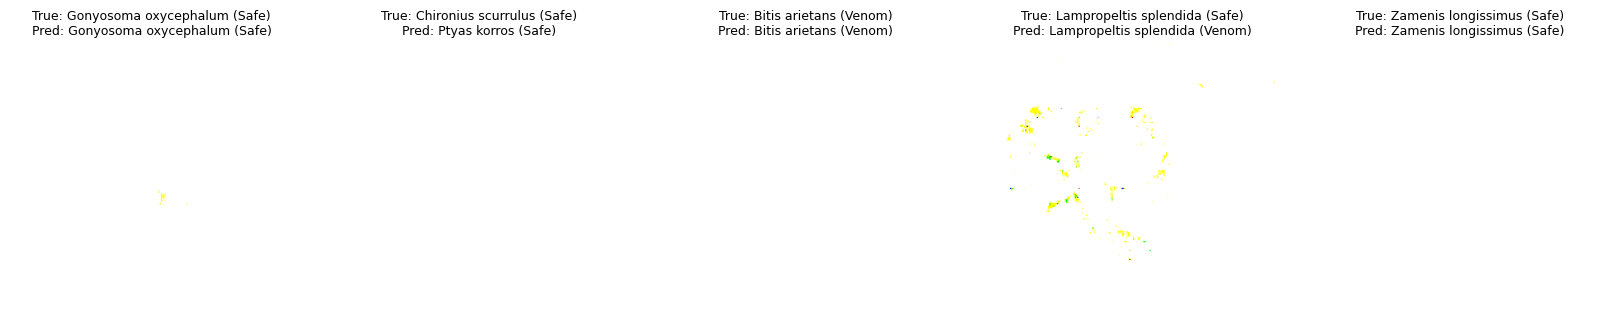

In [32]:
example_results_from_dataset(model, test_dataset, species_metadata, n_examples=5)

# Calculating scoring metrics

Function to tell if the species is venomous or not, based on encoded_id

In [21]:
get_scores(model, image_metadata, test_dataset, venom_threshold=0.5)

208/208 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step
=== Evaluation Metrics ===
1) Species accuracy: 0.0093
2) Macro-averaged F1 (species): 0.0039
3) Venom decision accuracy: 0.7352
4) Venom-weighted species accuracy: 0.2954


2025-11-18 19:45:39.507461: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'species_accuracy': 0.009328919650917845,
 'macro_f1': 0.003922443807710119,
 'venom_accuracy': 0.7351790550707192,
 'venom_weighted_species_accuracy': np.float64(0.2954124189063948),
 'y_species_true': array([284,   6, 291, ...,   8, 199,  60], shape=(6646,), dtype=int32),
 'y_species_pred': array([293, 214, 100, ..., 206, 284, 244], shape=(6646,)),
 'y_venom_true': array([1, 0, 0, ..., 1, 0, 1], shape=(6646,), dtype=int32),
 'y_venom_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(6646,))}